In [21]:
import pandas as pd
import datetime

def correct_anomalies(app, anomalies, date_index, tensor_traffic_original):

    temp = pd.DataFrame(index=date_index)
    temp['WeekDay_Index'] = date_index.weekday.values

    for dstr in anomalies.keys():

        if app in anomalies[dstr]:

            dts = datetime.datetime.strptime(dstr, '%Y%m%d')
            wdt = dts.weekday()
            idx = temp[temp['WeekDay_Index'] == wdt].index

            mask = [False] * len(date_index)
            for i in idx:
                j = [x.weekday() == i.weekday() for x in date_index]
                mask = np.logical_or(j, mask)
            mask = list(mask.flatten())

            masked_tensor = tensor_traffic_original[mask, :, :]
            avg = np.zeros((24, tensor_traffic_original.shape[1], tensor_traffic_original.shape[2]))

            for i in range(24):
                temp2 = masked_tensor[i::24]
                avg[i, :, :] += np.mean(temp2, axis=(0))
            day_anomaly_mask = [x.date() == datetime.datetime.strptime(dstr, '%Y%m%d').date() for x in date_index]
            tensor_traffic_original[day_anomaly_mask, :, :] = avg

    return tensor_traffic_original

def generate_datetimes(date_from_str='20200101', days=3):
    date_from = datetime.datetime.strptime(date_from_str, '%Y%m%d')
    dates = []
    for hour in range(24*days):
        dates.append(date_from + datetime.timedelta(hours=hour))
    return pd.Series(dates)

day_str_start = '20190316'#min ts: '20190316'
day_str_end = '20190531' #max ts: '20190531'
ts_start = datetime.datetime.strptime(day_str_start, '%Y%m%d')
ts_end = datetime.datetime.strptime(day_str_end, '%Y%m%d')
timestamps_index = generate_datetimes(date_from_str=day_str_start, days=1+(ts_end - ts_start).days)
date_index = pd.date_range(timestamps_index.iloc[0], periods=len(timestamps_index), freq='H')



In [22]:
import numpy as np

# Load .npy file
file_path = "/home/antonio/NetMOB23/nas_share/ST-ResNet/datasets/NetMob/Paris/Paris_Instagram_TrafficMapSeries_20190316_20190531.npy"

with open(file_path, 'rb') as f:
        tensor_traffic_original = np.load(f)

cdims=[409,346]

# Group tiles to create 1km x 1km macro-tiles (each macro_tile contains 10 cells)
pad_x = 10 - cdims[0] % 10
pad_y = 10 - cdims[1] % 10

tensor_traffic_original_t = np.pad(tensor_traffic_original, ((0,0), (0,pad_x),(0,pad_y)), 'constant', constant_values = 0)
tensor_traffic = tensor_traffic_original_t.reshape(tensor_traffic_original_t.shape[0], int((cdims[0] + pad_x) / 10),
                                        10, int((cdims[1] + pad_y) / 10), 10).sum(axis=(2, 4))

In [23]:
#Reshape the Data from (1848, 41, 35) to (1848, 2, 41, 35)
display(tensor_traffic.shape)

tensor_traffic_reshape = np.reshape(tensor_traffic, (1848, 1, 41, 35))

tensor_traffic_reshape_2 = np.concatenate((tensor_traffic_reshape, tensor_traffic_reshape), axis=1)

display(tensor_traffic_reshape.shape)

(1848, 41, 35)

(1848, 1, 41, 35)

In [47]:
import h5py
f = h5py.File('/home/antonio/NetMOB23/ST-ResNet/datasets/NetMob/Paris/Paris_Instagram_TrafficMapSeries_20190316_20190531_REDUCED.h5')
for ke in f.keys():
    print(ke, f[ke].shape)

date_arr = np.array(f['date'][:1848])

data_arr_b = np.array(f['data'])
date_arr_b = np.array(f['date'])

#data_arr = np.array(f['data'])
date_arr = np.array(f['date'])
data_arr = np.array(f['data'][:,0,:,:])


data (1848, 2, 41, 35)
date (1848,)


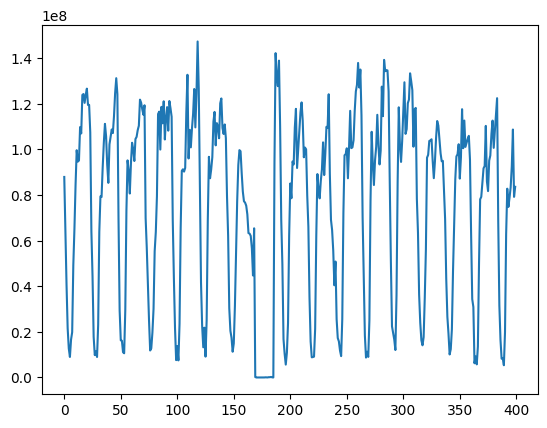

In [25]:
import matplotlib.pyplot as plt

plt.plot(tensor_traffic[1200:1600,20,20])
plt.show()

In [26]:

anomalies = {'20190414': ['Instagram', 'Facebook', 'Twitter', 'Facebook_Live', 'WhatsApp'],
             '20190512': ['Instagram', 'Facebook', 'Netflix', 'YouTube', 'Facebook_Live',
                          'Twitter', 'Twitch', 'DailyMotion', 'Web_Streaming', 'WhatsApp',
                          'Orange_TV']}
app = 'Instagram'

tensor_traffic_original_correct = correct_anomalies(app, anomalies, date_index, tensor_traffic)


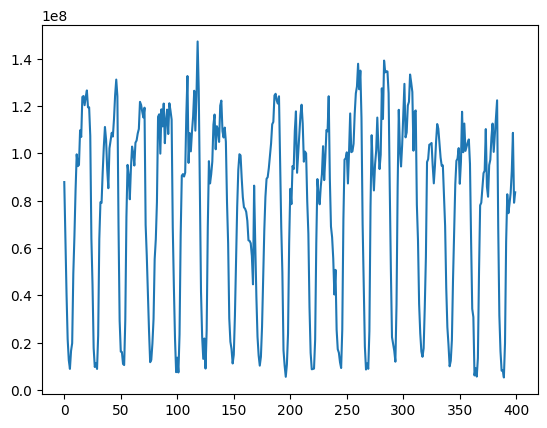

In [27]:
import matplotlib.pyplot as plt

plt.plot(tensor_traffic[1200:1600,20,20])
plt.show()

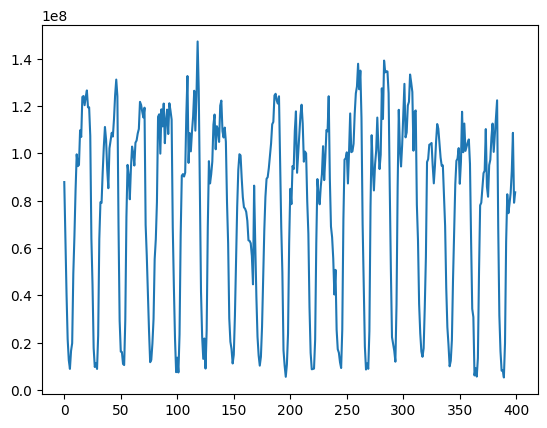

In [28]:
import matplotlib.pyplot as plt

plt.plot(tensor_traffic_original_correct[1200:1600,20,20])
plt.show()


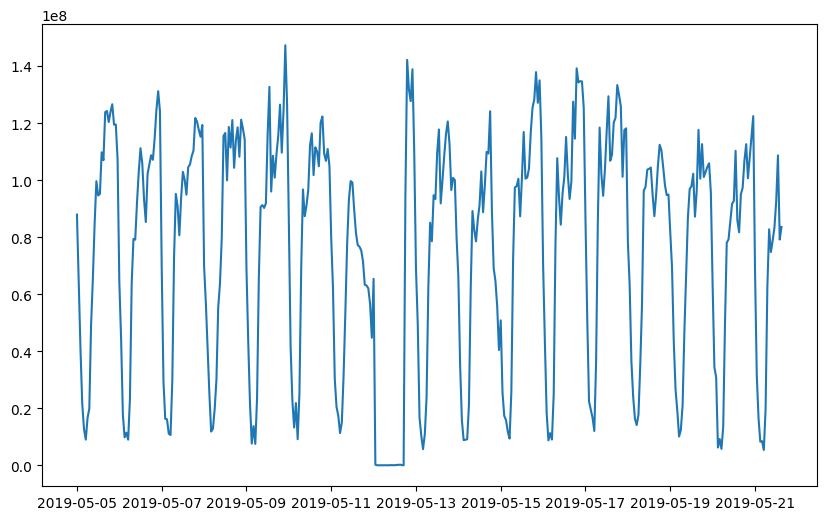

In [30]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.plot(date_index[1200:1600],data_arr[1200:1600,20,20])
plt.show()

In [65]:
#Reshape the Data from (1848, 41, 35) to (1848, 2, 41, 35)
display(tensor_traffic_original_correct.shape)

tensor_traffic_reshape = np.reshape(tensor_traffic_original_correct, (1848, 1, 41, 35))

tensor_traffic_reshape_2 = np.concatenate((tensor_traffic_reshape, tensor_traffic_reshape), axis=1)

display(tensor_traffic_reshape.shape)

(1848, 41, 35)

(1848, 1, 41, 35)

In [73]:
import h5py
import numpy as np
import datetime

def conver_date (date_bytes):
    if date_bytes[-2:] == b'00':
        new_date_bytes = date_bytes[:-2] + b'24'
        new_date_bytes = str(int(new_date_bytes) - 100).encode('utf-8')
    else:
        new_date_bytes = date_bytes
    return new_date_bytes

data_arr = tensor_traffic_reshape
date_arr =  [dt.strftime('%Y%m%d%H').encode('utf-8') for dt in date_index]
data_arr_t = [conver_date(dt) for dt in date_arr]
date_arr = np.array(data_arr_t)

with h5py.File('Paris_Instagram_TrafficMapSeries_20190316_20190531_REDUCED_CORRECT.h5', 'w') as hf:
    # Create a dataset inside the file
    hf.create_dataset('data', data=data_arr)
    hf.create_dataset('date', data=date_arr)

In [67]:
import h5py
f = h5py.File('/home/antonio/NetMOB23/ST-ResNet/datasets/NetMob/Paris/Paris_Instagram_TrafficMapSeries_20190316_20190531_REDUCED_CORRECT.h5')
for ke in f.keys():
    print(ke, f[ke].shape)
    
data_arr_b = np.array(f['data'])
date_arr_b = np.array(f['date'])

f.close()

data (1848, 1, 41, 35)
date (1848,)


In [71]:
import h5py
f = h5py.File('/home/antonio/NetMOB23/ST-ResNet/datasets/NetMob/Paris/Paris_Instagram_TrafficMapSeries_20190316_20190531_REDUCED_1.h5')
for ke in f.keys():
    print(ke, f[ke].shape)

data_arr_t = np.array(f['data'])
date_arr_t = np.array(f['date'])

f.close()

data (1848, 1, 41, 35)
date (1848,)


In [64]:
with h5py.File('Paris_Instagram_TrafficMapSeries_20190316_20190531_REDUCED_CORRECT.h5', 'w') as hf:
    # Create a dataset inside the file
    hf.create_dataset('data', data=data_arr)
    hf.create_dataset('date', data=date_arr_t)